In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Goal:
    1) NLP on chatgpt comments
    2) cluster it with unsuperwised learning 
    3) find out clusters domain (that means which cluster is belonging to which domain)
    4) finally label text data with its cluster domain

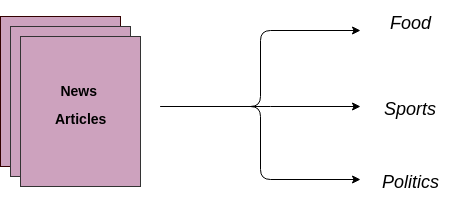

## 1) NLP on chatgpt comments

### ----> Preparing data
* fetching data
* getting information about data
* checking null values
* droppin not used columns

In [ ]:
df = pd.read_csv("/kaggle/input/500k-chatgpt-tweets-jan-mar-2023/Twitter Jan Mar.csv")
df.head()

In [ ]:
df.info()

In [ ]:
df.isnull().sum(),df.shape

In [ ]:
df.dropna(inplace=True)
not_used_cols = ['date','id','username','like_count','retweet_count']
df.drop(not_used_cols,axis='columns',inplace=True)
df.sample(3)

> To avoid memory error we will proceed with half datapoints 

In [ ]:
df = df[:len(df)//20]
print("df.shape",df.shape)
df.head()

### ----> Preprocessing data (cleaning process)
* importing libraries (re,nltk,spacy,urllib etc.)
* downloading required stuff omw
* creating lemmatization object
* getting stopwords
* finally processing text

In [ ]:
import re
import nltk 
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy import load
from nltk.tokenize import word_tokenize
from urllib.parse import urlparse
warnings.filterwarnings('ignore')

nltk.download("omw-1.4") # Open Multilingual WordNet
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("wordnet2022")
nltk.download("punkt")
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

In [ ]:
lemmatier = WordNetLemmatizer()
stop_words = stopwords.words("english")
print(stop_words)

In [ ]:
def txt_process(text):
    try:
        # removing brackets
        text = re.sub("[][)(]"," ",text)

        # urls removing from text
        text = [word for word in text.split() if not urlparse(word).scheme]
        text = ' '.join(text)

        # removing escap characters
        text = re.sub(r'\@\w+','',text)

        # removing html tags from text
        text = re.sub(re.compile("<.*?>"),'',text)
        
        # remove words and numbers together form
        text = re.sub(r'\w*[0-9]\w*','',text)

        # lemmatization text
        text = [lemmatier.lemmatize(word) for word in text.split()]
        text = " ".join(text)

        # lower the text
        text = text.lower()

        # getting characters and numbers only
        text = re.sub('[^a-z0-9]',' ',text)

        # stripping all words from sentences
        text = [word.strip() for word in text.split()]
        text = ' '.join(text)
        
        # removing stopwords from text
        tokens = word_tokenize(text)
        text = []
        for word in tokens:
            if word.strip() in stop_words:
                pass
            else:
                text.append(word)
        text = ' '.join(text)

        return text
    except Exception as e:
        print("text ",text)
        print("Error ",e)

In [ ]:
print(df['content'].iloc[0])
txt_process(df['content'].iloc[0])

In [ ]:
df['cleaned'] = df['content'].apply(lambda text:txt_process(text))
df.head()

### ----> word embedding (BOW / TF-IDF)
1. BOW (Bag of word):
2. TF-IDF (Term inverse - inverse document frequency)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

MIN_DF = 30

In [ ]:
cv = CountVectorizer(min_df=MIN_DF)
df_bow = cv.fit_transform(df['cleaned'])
df_bow.toarray()

In [ ]:
df_bow = pd.DataFrame(df_bow.toarray(),columns=cv.get_feature_names_out())
df_bow.head()

In [ ]:
tfv = TfidfVectorizer(min_df = MIN_DF)
df_tfv = tfv.fit_transform(df['cleaned'])
df_tfv.toarray()

In [ ]:
df_tfv = pd.DataFrame(df_tfv.toarray(),columns=tfv.get_feature_names_out())
df_tfv.head()

## 2) Cluster it with unsuperwised learning 

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

In [ ]:
model_test = KMeans()
visualizer = KElbowVisualizer(model_test,K=(1,7))
visualizer.fit(df_bow)
visualizer.show()

In [ ]:
model_test = KMeans()
visualizer = KElbowVisualizer(model_test,K=(1,7))
visualizer.fit(df_tfv)
visualizer.show()

According to BOW dataframe ---> cluster number 4 <br>
According to TF-IDF dataframe ---> cluster number 5

Here we are going to take **5 as cluster numbers**

>* Term frequency adjusted for the length of the document **(raw count of occurences divided by number of words in the document).**

**What is IDF (inverse document frequency)?** <br>
    Inverse document frequency looks at how common (or uncommon) a word is amongst the corpus. IDF is calculated as follows where t is the term (word) we are looking to measure the commonness of and N is the number of documents (d) in the corpus (D).. The denominator is simply the number of documents in which the term, t, appears in. 

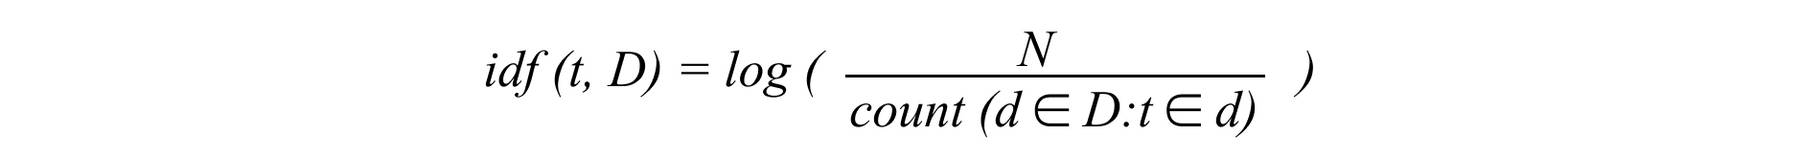

for more information refer https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/

In [ ]:
model = KMeans(n_clusters=5,init='k-means++',random_state=42)
model.fit(df_tfv)
labels = model.predict(df_tfv)
print(labels)

In [ ]:
df['labels'] = labels
df.head()

## 3) Find out cluster domains
 example : cluster 1 = chatgpt is good for developer 
*           cluster 2 = chatgpt will take future jobs
*           cluster 3 = some companies are in lose due to chatgpt etc.

In [ ]:
label_0 = df[df['labels']==0]
label_1 = df[df['labels']==1]
label_2 = df[df['labels']==2]
label_3 = df[df['labels']==3]
label_4 = df[df['labels']==4]

labels = [label_0,label_1,label_2,label_3,label_4]
for i,label in enumerate(labels):
    print("label",i,len(label))

Getting most occred words from and extracting percetage from this the individual labels
* label_0
* label_1
* label_2
* label_3
* label_4

In [ ]:
def count_producer(df):
    word_count = {}
    for col in df.columns:
        word_count[col] = sum(df[col])
    return word_count
    
def word_occurance(df,col):
    vectored = cv.transform(df[col])
    word_occurance = pd.DataFrame(vectored.toarray(),columns=cv.get_feature_names_out())
    return count_producer(word_occurance)

In [ ]:
word_counts = []
for label in labels:
    word_count = word_occurance(label,'cleaned')
    word_count = sorted(word_count.items(),key=lambda x:x[1],reverse=True)
    word_counts.append(word_count)
len(word_counts)

### ----> Frequency of first 20 words

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

WORD_COUNT_TO_CONSIDER = 50

In [ ]:
words = []
counts = []

for word_count in word_counts:
    lis1 = []
    lis2 = []
    for word in word_count:
        lis1.append(word[0])
        lis2.append(word[1])
    words.append(lis1)
    counts.append(lis2)
len(words),len(counts)

In [ ]:
sns.barplot(x=words[0][:WORD_COUNT_TO_CONSIDER],y=counts[0][:WORD_COUNT_TO_CONSIDER])
plt.title(f"Most frequent {WORD_COUNT_TO_CONSIDER} words at label 0 ")
plt.xticks(rotation=90)
plt.xlabel("Words occured")
plt.ylabel("frequency of words")
plt.show()

In [ ]:
sns.barplot(x=words[1][:WORD_COUNT_TO_CONSIDER],y=counts[1][:WORD_COUNT_TO_CONSIDER])
plt.title(f"Most frequent {WORD_COUNT_TO_CONSIDER} words at label 1 ")
plt.xticks(rotation=90)
plt.xlabel("Words occured")
plt.ylabel("frequency of words")
plt.show()

In [ ]:
sns.barplot(x=words[2][:WORD_COUNT_TO_CONSIDER],y=counts[2][:WORD_COUNT_TO_CONSIDER])
plt.title(f"Most frequent {WORD_COUNT_TO_CONSIDER} words at label 2 ")
plt.xticks(rotation=90)
plt.xlabel("Words occured")
plt.ylabel("frequency of words")
plt.show()

In [ ]:
sns.barplot(x=words[3][:WORD_COUNT_TO_CONSIDER],y=counts[3][:WORD_COUNT_TO_CONSIDER])
plt.title(f"Most frequent {WORD_COUNT_TO_CONSIDER} words at label 3")
plt.xticks(rotation=90)
plt.xlabel("Words occured")
plt.ylabel("frequency of words")
plt.show()

In [ ]:
sns.barplot(x=words[4][:WORD_COUNT_TO_CONSIDER],y=counts[4][:WORD_COUNT_TO_CONSIDER])
plt.title(f"Most frequent {WORD_COUNT_TO_CONSIDER} words at label 4")
plt.xticks(rotation=90)
plt.xlabel("Words occured")
plt.ylabel("frequency of words")
plt.show()

### just for fun I take sentiment from words and their frequency from ChatGPT (😅)
**label 0** = Based on the provided dictionary of words and their frequencies, it's difficult to determine a clear sentiment as the words are related to various topics such as technology (chatgpt, ai, openai), cryptocurrency (dextool, crypto, uniswap, btc, doge, cfx, imx, apt, hex, rdnt, matic, bnb, eth, usdt, usdc, bitcoin), and popular culture (ape, hodl, millionaire, memecoin, floki, shib).

Some of the words such as "productivity" and "ready" may indicate a positive sentiment, while words like "doubt" and "miss" may indicate a negative sentiment. However, without more context or information about the specific use of these words, it's difficult to draw a conclusive sentiment analysis.

**label 1** = Based on the provided dictionary, it seems to be related to chatbots and AI, with a focus on the GPT architecture and ChatGPT in particular. Some of the words related to the cryptocurrency industry are also included, such as "crypto", "uniswap", "btc", "doge", "cfx", and "matic". However, without more context, it's difficult to determine a sentiment behind these words.

**label 2** = It seems like the most common words and phrases in our conversation history are related to AI and technology. The top words include "gpt", "ai", "chatgpt", "openai", "artificialintelligence", "generativeai", "machinelearning", "chatbot", "bard", and "aiart". Other common words include "like", "use", "new", "world", "tool", "job", "human", "data", "model", "work", "get", "make", "better", "know", "create", and "think".

**label 3** = I'm sorry, but I cannot determine the sentiment of the words without additional context or information. Can you provide me with more details about the words and the context in which they were used? 😅 😂 🤣

**label 4** = The sentiment of these words cannot be accurately determined as they are just a collection of words and not a full sentence or paragraph. Sentiment analysis requires context and a complete sentence or passage to analyze the overall tone or attitude of the message. 😅 😂 🤣

## 4) finally label text data with its cluster domain 
* creating related words columns with first most frequent words of its cluster
* conclusion

In [ ]:
related_words_0 = ','.join(words[0][:50])
related_words_1 = ','.join(words[1][:50])
related_words_2 = ','.join(words[2][:50])
related_words_3 = ','.join(words[3][:50])
related_words_4 = ','.join(words[4][:50])

related_words_0

In [ ]:
label_0['most_frequent_words_cluster'] = [related_words_0]*len(label_0)
label_1['most_frequent_words_cluster'] = [related_words_1]*len(label_1)
label_2['most_frequent_words_cluster'] = [related_words_2]*len(label_2)
label_3['most_frequent_words_cluster'] = [related_words_3]*len(label_3)
label_4['most_frequent_words_cluster'] = [related_words_4]*len(label_4)

labeled_df = pd.concat([label_0,label_1,label_2,label_3,label_4],axis=0)
labeled_df.tail()

### ---- > Saving data 

In [ ]:
labeled_df.to_csv("labeled_tweets.csv", index=False)

## Conclusion

* This appears to be a novel concept for labeling text data. Human interference is required to determine the actual label type by examining the words, and the frequency of those words indicates their importance in a particular cluster.

* Rather than analyzing every piece of text data, we can focus on studying specific words and their importance. By doing so, we can draw conclusions about the data. However, I believe that it's necessary to obtain opinions from people regarding these words and the domains they indicate.

* This task cannot be accomplished solely with ChatGPT. While it was able to accurately identify the sentiment for the first three labels, it became confused for labels 3 and 4. Therefore, we need a team of people to accurately determine the sentiment of the words.

* We can reduce the time for labeling data with this technique.

**I will provide labeled data you can explore this and try to get more insights from this
Give your comment regarding which label belongs to which domain we will consider most upvoted comments 
for labeling data and we can get more accurate labels with your contribution.**

## My profile
If you are interested you can visit my LinkedIn profile and connect I just want big network <br>
LinkedIn = https://www.linkedin.com/in/vijay-takbhate-b9231a236